# Volume 3: Gibbs Sampling and LDA
    <Name>
    <Class>
    <Date>

In [1]:
import numpy as np
from math import sqrt
from scipy.special import gammaln
from scipy.stats import norm, invgamma, gaussian_kde
from matplotlib import pyplot as plt

## Problem 1

Implement a Gibbs sampler for the exam scores problem (using the data in `examscores.npy`).
Test your sampler with priors $\nu=80$, $\tau^{2} = 16$, $\alpha = 3$, and $\beta = 50$, collecting $1000$ samples.
Plot your samples of $\mu$ and your samples of $\sigma^{2}$.

In [11]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    N = len(y)
    
    mus = [np.mean(y)]
    sigs = [np.var(y)]
    
    mu = mus[-1]
    sig2 = sigs[-1]
    
    # Take n_samples
    for k in range(n_samples):
        sig2_star = (1/tau2 + N/sig2)**(-1)
        mu_star = sig2_star * (nu/tau2 + 1/sig2 * sum(y))
        alpha_star = alpha + N/2
        beta_star = beta + 1/2*sum([(yi - mu)**2 for yi in y])
        
        
        mu = norm.rvs(mu_star, scale=np.sqrt(sig2_star))
        sig2 = invgamma.rvs(alpha_star, scale=beta_star)
        
        mus.append(mu)
        sigs.append(sig2)
        
    return mus, sigs

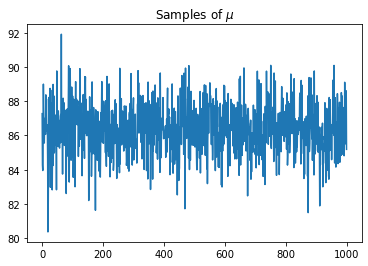

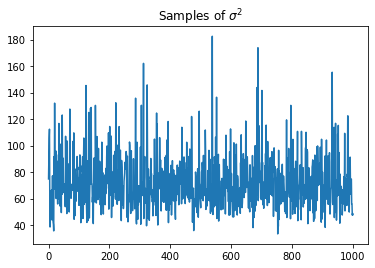

In [19]:
y = np.load('examscores.npy')
nu = 80
tau2 = 16
alpha = 3
beta = 50
n_samples = 1000
mus, sigs = gibbs(y, nu, tau2, alpha, beta, n_samples)

plt.plot(mus)
plt.title(r"Samples of $\mu$")
plt.show()

plt.plot(sigs)
plt.title(r"Samples of $\sigma^2$")
plt.show()

## Problem 2

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

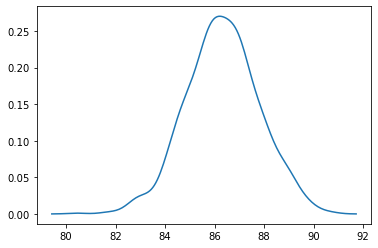

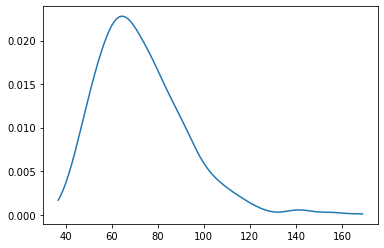

In [14]:
mu_kernel = gaussian_kde(mus)
x = np.linspace(min(mus) - 1, max(mus) + 1, 200)
plt.plot(x, mu_kernel(x))
plt.show()

sig_kernel = gaussian_kde(sigs)
x = np.linspace(min(sigs) - 1, max(sigs) + 1, 200)
plt.plot(x, sig_kernel(x))
plt.show()

## Problem 3

Implement `LDACGS.initialize()`.
By randomly assigning initial topics, fill in the count matrices and topic assignment dictionary.
In this method, you will initialize the count matrices (among other things).

To be explicit, you will need to initialize $nmz$, $nzw$, and $nz$ to be zero arrays of the correct size.
Then, in the second for loop, you will assign z to be a random integer in the correct range of topics.
In the increment step, you need to figure out the correct indices to increment by one for each of the three arrays.
Finally, assign $topics$ as given.

## Problem 4

Complete `LDACGS._sweep()`, which needs to iterate through each word of each document.
It should call `LDACGS._conditional()` to get the conditional distribution at each iteration.

Note that the first part of this method will undo what `LDACGS.initialize()` did.
Then we will use the conditional distribution (instead of the uniform distribution we used previously) to pick a more accurate topic assignment.
Finally, the latter part repeats what we did in `LDACGS.initialize()`, but does so using this more accurate topic assignment.

## Problem 5

Complete `LDACGS.sample()`.
The argument `filename` is the name and location of a .txt file, where each line is considered a document.
The corpus is built by `LDACGS.buildCorpus()`, and stopwords are removed (if argument `stopwords` is provided).
Burn in the Gibbs sampler, computing and saving the log-likelihood with the method `_loglikelihood()`.
After the burn in, iterate further, accumulating your count matrices, by adding `nzw` and `nmz` to `total_nzw` and `total_nmz` respectively, where you only add every `sample_rate`th iteration. 
Also save each log-likelihood.

In [46]:
class LDACGS:
    """Do LDA with Gibbs Sampling."""

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """Initialize system parameters."""
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self, filename, stopwords_file=None):
        """Read the given filename and build the vocabulary."""
        with open(filename, 'r') as infile:
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        if stopwords_file:
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        self.documents = []
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        """Initialize the three count matrices."""
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        
        # Initialize the three count matrices.
        # The (i,j) entry of self.nmz is the number of words in document i assigned to topic j.
        self.nmz = np.zeros((self.n_docs, self.n_topics))
        
        # The (i,j) entry of self.nzw is the number of times term j is assigned to topic i.
        self.nzw = np.zeros((self.n_topics, self.n_words))
        
        # The (i)-th entry is the number of times topic i is assigned in the corpus.
        self.nz = np.zeros(self.n_topics)

        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z

        for m in range(self.n_docs):
            for i, w in self.documents[m].items():
                # Get random topic assignment, i.e. z = ...
                z = np.random.randint(self.n_topics)
                
                # Increment count matrices
                # Number of words in doc m assigned to topic z
                self.nmz[m,z] = self.nmz[m,z] + 1
                # Number of times term i is assigned to topic z
                self.nzw[z,w] = self.nzw[z,w] + 1
                # Number of times topic z is assigned
                self.nz[z] = self.nz[z] + 1
                
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                self.topics[(m, i)] = z
                

    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        self.buildCorpus(filename, stopwords_file)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics, self.n_words))
        self.total_nmz = np.zeros((self.n_docs, self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in range(burnin):
            # Sweep and store log likelihood.
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
        for i in range(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i+burnin] = self._loglikelihood()
            if not i % sample_rate:
                # accumulate counts
                self.total_nzw = self.total_nzw + self.nzw
                self.total_nmz = self.total_nmz + self.nmz

    def phi(self):
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        lines = np.zeros((self.n_topics,n_lines))
        for i in range(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self, stopwords):
        return [x for x in self.vocab if x not in stopwords]

    def _conditional(self, m, w):
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist / np.sum(dist)

    def _sweep(self):
        for m in range(self.n_docs):
            for i,w in self.documents[m].items():
                # Retrieve topic assignment for i-th word in document m.
                z = self.topics[(m, i)]
                # Decrement count matrices.
                self.nmz[m,z] = self.nmz[m,z] - 1
                self.nzw[z,w] = self.nzw[z,w] - 1
                self.nz[z] = self.nz[z] - 1
                
                # Get conditional distribution.
                cond = self._conditional(m, w)
                # Sample new topic assignment.
                new_z = np.random.choice(self.n_topics, p=cond)
                
                # Increment count matrices.
                self.nmz[m,new_z] = self.nmz[m,new_z] + 1 
                self.nzw[new_z,w] = self.nzw[new_z,w] + 1 
                self.nz[new_z] = self.nz[new_z] + 1 
                
                # Store new topic assignment.
                self.topics[(m, i)] = new_z
            
    def _loglikelihood(self):
        lik = 0

        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik
    


## Problem 6

Create an `LDACGS` object with $20$ topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn in of $100$ iterations, accumulating $10$ samples, only keeping the results of every $10$th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods. How long did it take to burn in?

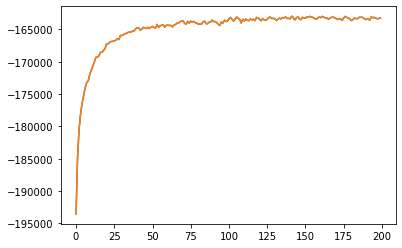

In [47]:
test = LDACGS(20)
test.sample("reagan.txt", stopwords_file="stopwords.txt")
plt.plot(test.logprobs)

## Problem 7

Using `topterms()` to examine the topics for Reagan's addresses.
Come up with labels for each topic.
If `ntopics=20` and `n=10`, we will get the top $10$ words that represent each of the $20$ topics; for each topic, decide what these ten words jointly represent.

In [61]:
topics = ["Government", "Taxes", "Technology/Space", "Budget", 
          "Patriotism", "Democracy", "American History", "Growth", 
          "War", "Comfort", "Patriotism", "Prosperity", 
          "Addresses", "Tragedies", "Families", "Abortion",
          "Republican", "Defense", "Culture", "Policies"]

for i, topic in zip(test.topterms(), topics):
    print("------", topic, "------")
    print(i)
    print()

------ Government ------
['states', 'united', 'local', 'time', '50', "i've", 'governments', 'state', 'well,', 'flexibility']

------ Taxes ------
['tax', 'economic', 'rates', 'interest', 'inflation', 'government', 'rate', 'program', '--', 'increase']

------ Technology/Space ------
['space', 'develop', 'build', 'research', 'earth.', 'technology', "we're", 'frontier', 'make', 'space.']

------ Budget ------
['federal', 'billion', 'spending', 'government', 'budget', 'growth', 'programs', 'reduce', 'years', 'years.']

------ Patriotism ------
['god', 'you,', 'bless', "let's", 'veto', '43', 'you.', 'give', 'america.', 'work']

------ Democracy ------
['freedom', 'democratic', 'people', 'democracy', 'central', 'support', 'freedom.', 'america.', 'soviet', 'people.']

------ American History ------
['day', 'historic', 'franklin', 'began', 'president', 'rising', 'well,', 'growing', 'washington', 'ago']

------ Growth ------
['private', 'jobs', 'programs', 'work', 'welfare', 'americans', 'conti